In [1]:
!pip install opencv-python
!pip install tensorflow

In [2]:
import pandas as pd 
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, classification_report, roc_curve, auc, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical

In [3]:
base_path = os.getcwd() 
base_path

'D:\\Northeastern\\Fall2024\\DS5220\\Project'

##### get all the train data from the train folder

In [4]:
train_data = []
train_folder = os.path.join(base_path, 'asl_alphabet_train')

for folder in os.listdir(train_folder):
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) 
                 if os.path.isfile(os.path.join(label_folder, f))]
    train_data += onlyfiles
    
train_df = pd.DataFrame(train_data)

In [5]:
train_df

,label,path
0,A,D:\Northeastern\Fall2024\DS5220\Project\asl_al...
1,A,D:\Northeastern\Fall2024\DS5220\Project\asl_al...
2,A,D:\Northeastern\Fall2024\DS5220\Project\asl_al...
3,A,D:\Northeastern\Fall2024\DS5220\Project\asl_al...
4,A,D:\Northeastern\Fall2024\DS5220\Project\asl_al...
...,...,...
86995,Z,D:\Northeastern\Fall2024\DS5220\Project\asl_al...
86996,Z,D:\Northeastern\Fall2024\DS5220\Project\asl_al...
86997,Z,D:\Northeastern\Fall2024\DS5220\Project\asl_al...
86998,Z,D:\Northeastern\Fall2024\DS5220\Project\asl_al...


# EDA

In [6]:
labels = train_df['label'].unique().tolist()
print(labels)

['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87000 entries, 0 to 86999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   87000 non-null  object
 1   path    87000 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [8]:
 train_df.isnull().sum()

label    0
path     0
dtype: int64

In [9]:
image_shapes = []
for path in tqdm(train_df['path']):
    img = cv2.imread(path)
    image_shapes.append(img.shape)
pd.DataFrame(image_shapes, columns=['Height', 'Width', 'Channels']).describe()

100%|██████████████████████████████████████████████████████████████████████████| 87000/87000 [00:40<00:00, 2171.20it/s]


,Height,Width,Channels
count,87000.0,87000.0,87000.0
mean,200.0,200.0,3.0
std,0.0,0.0,0.0
min,200.0,200.0,3.0
25%,200.0,200.0,3.0
50%,200.0,200.0,3.0
75%,200.0,200.0,3.0
max,200.0,200.0,3.0


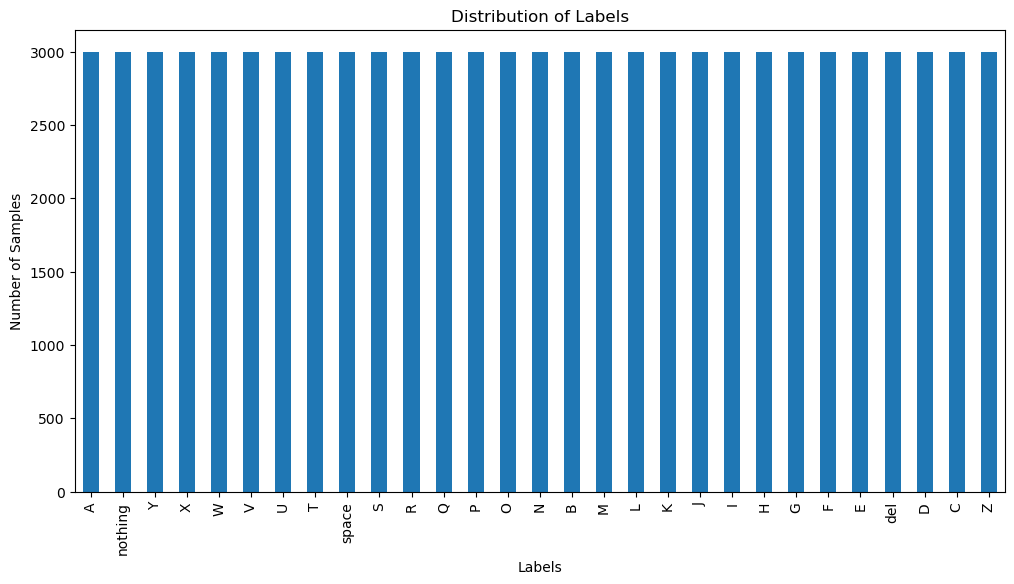

In [10]:
label_counts = train_df['label'].value_counts()
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Number of Samples")
plt.show()

In [11]:
def show_image(label, size):
    rows = train_df[train_df['label']==label]['path']
    rand_img = random.randint(a=0, b=len(rows))
    filepath = rows.iloc[rand_img]
    
    img = cv2.imread(filepath)
    img = cv2.resize(img, size)
    
    plt.figure()
    plt.imshow(img)

##### images with different size

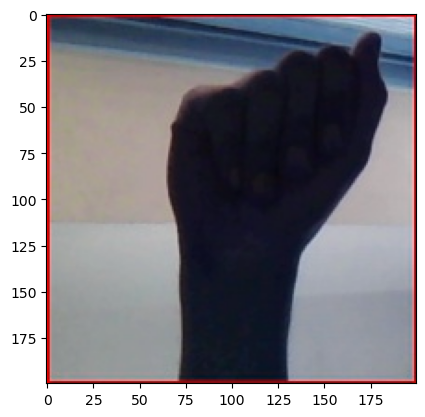

In [12]:
original_size = 200, 200
show_image('A', original_size)

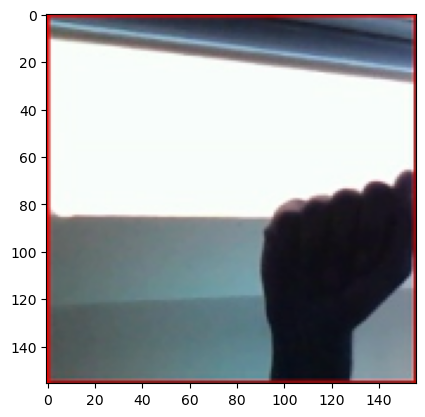

In [13]:
size = 156, 156
show_image('A', size)

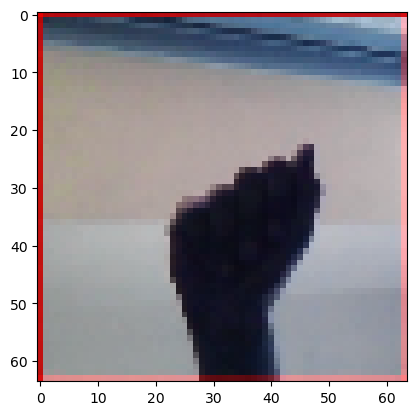

In [14]:
size = 64,64
show_image('A', size)

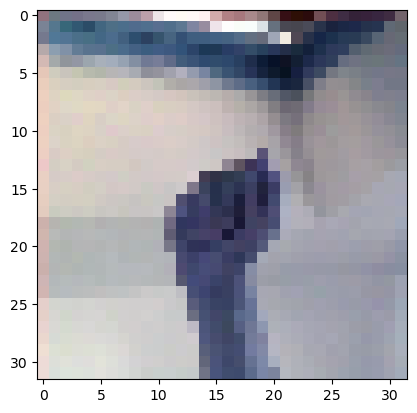

In [15]:
size = 32,32
show_image('A', size)

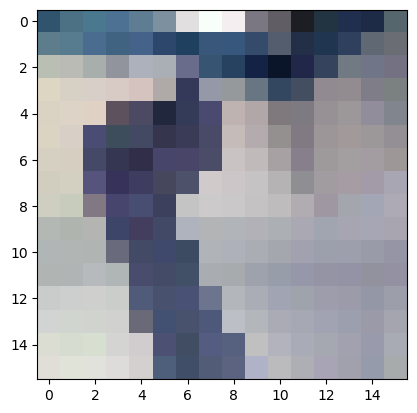

In [16]:
size = 16,16
show_image('A', size)

=> let's choose 32,32 size to train model and choose 16, 16 for reduced size to train CNN  models

In [17]:
target_size = 32,32
reduced_size = 16, 16

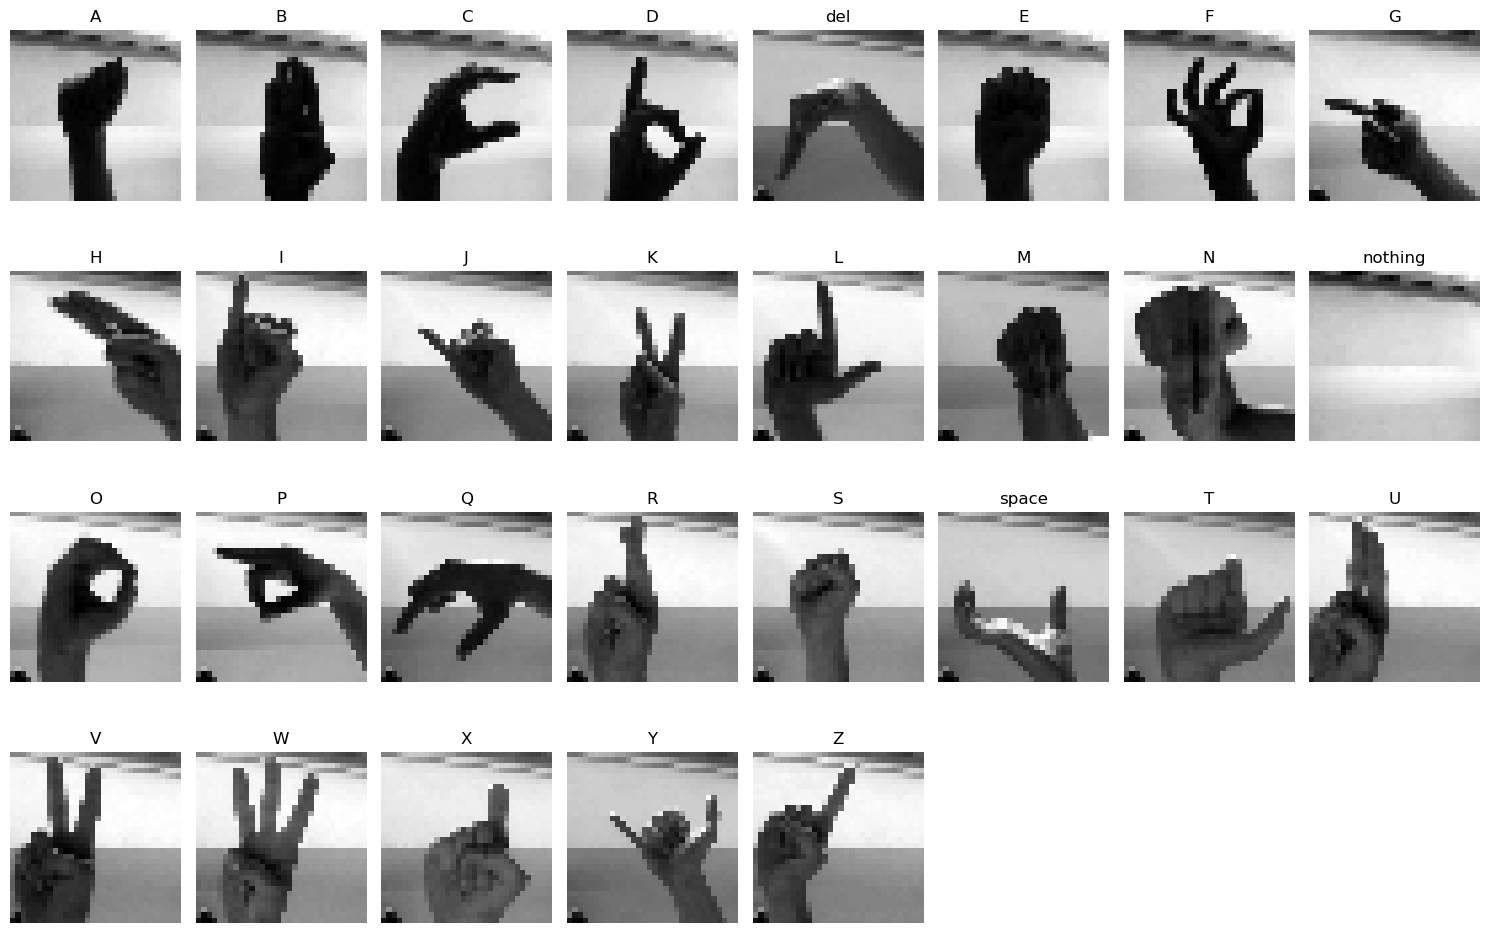

In [18]:
labels = train_df['label'].unique()  # Get unique labels
    
plt.figure(figsize=(15, 10))
for i, label in enumerate(labels):
    label_row = train_df[train_df['label'] == label].iloc[0]
    image_path = label_row['path']
    
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, target_size)

    plt.subplot(4, 8, i + 1)
    plt.imshow(img_resized, cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

##### Some of the letters have  similar symbols:
-  A is similar to E
-  M and N are similar
-  V and K are similar
-  ...

=> Check models with 2 letters that have similar and different shapes to compare.

# Data Processing:

In [19]:
# X = []
# y = []

# for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
#     img = cv2.imread(row['path'], cv2.IMREAD_GRAYSCALE) 
#     img_resized = cv2.resize(img, target_size)
#     img_flattened = img_resized.flatten()
    
#     X.append(img_flattened)
#     y.append(row['label'])

# X = np.array(X)
# y = np.array(y)

def preprocess_images(size):
    """
    Preprocess images to a specific size and flatten them.
    """
    X = []
    y = []

    for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
        img = cv2.imread(row['path'], cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, size)
        img_normalized = img_resized.astype('float32') / 255.0
        
        X.append(img_normalized)
        y.append(row['label'])

    X = np.array(X)
    y = np.array(y)
    return X, y

# Modelling:

#### 1. Logistic Regression:

In [20]:
def logistic_regression_binary(label_1, label_2, size, roc_label):
    """
    Train a logistic regression model  using two specific labels.
    """
    X, y = preprocess_images(size)
    
    mask = (y == label_1) | (y == label_2)
    X_binary = X[mask]
    y_binary = y[mask]
    
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_binary)

    X_train, X_test, y_train, y_test = train_test_split(X_binary, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    print("Training")
    logistic_model = LogisticRegression()
    logistic_model.fit(X_train, y_train)

    print("Evaluating")
    y_pred = logistic_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

    print('Accuracy: ' + str(accuracy))
    print('Confusion Matrix: ')
    print(conf_matrix)
    print('Recall: ' + str(recall))
    print('Precision: ' + str(precision))
    print('F1_score: ' + str(f1))
    print('Classification Report: ')
    print(report)

    # plot the ROC and AUC
    y_prob = logistic_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.title(roc_label)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

#### Two similar letters:

100%|██████████████████████████████████████████████████████████████████████████| 87000/87000 [00:35<00:00, 2428.75it/s]


Training
Evaluating
Accuracy: 0.875
Confusion Matrix: 
[[538  62]
 [ 88 512]]
Recall: 0.875
Precision: 0.8757054914227828
F1_score: 0.8749412918842456
Classification Report: 
              precision    recall  f1-score   support

           A       0.86      0.90      0.88       600
           E       0.89      0.85      0.87       600

    accuracy                           0.88      1200
   macro avg       0.88      0.88      0.87      1200
weighted avg       0.88      0.88      0.87      1200



C:\Users\Victoria\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


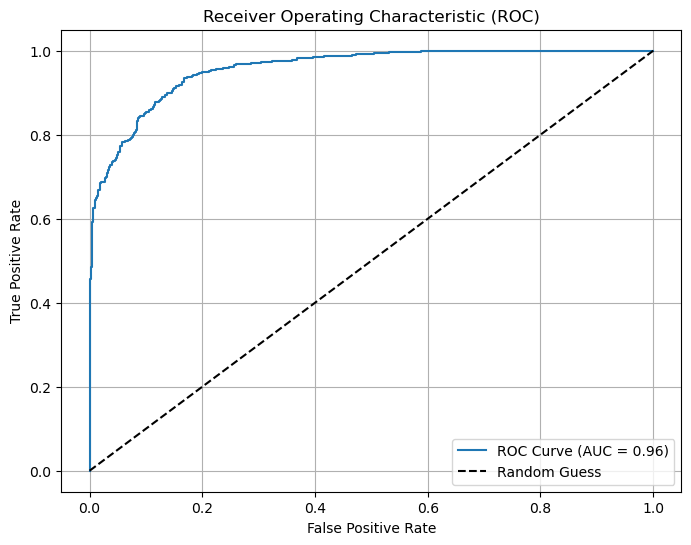

In [21]:
label_1 = "A"
label_2 = "E"
logistic_regression_binary(label_1, label_2, target_size, 'Two similar letters (ROC))

#### Two different letters:

100%|██████████████████████████████████████████████████████████████████████████| 87000/87000 [00:36<00:00, 2411.82it/s]


Training
Evaluating
Accuracy: 1.0
Confusion Matrix: 
[[600   0]
 [  0 600]]
Recall: 1.0
Precision: 1.0
F1_score: 1.0
Classification Report: 
              precision    recall  f1-score   support

           C       1.00      1.00      1.00       600
           G       1.00      1.00      1.00       600

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



C:\Users\Victoria\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


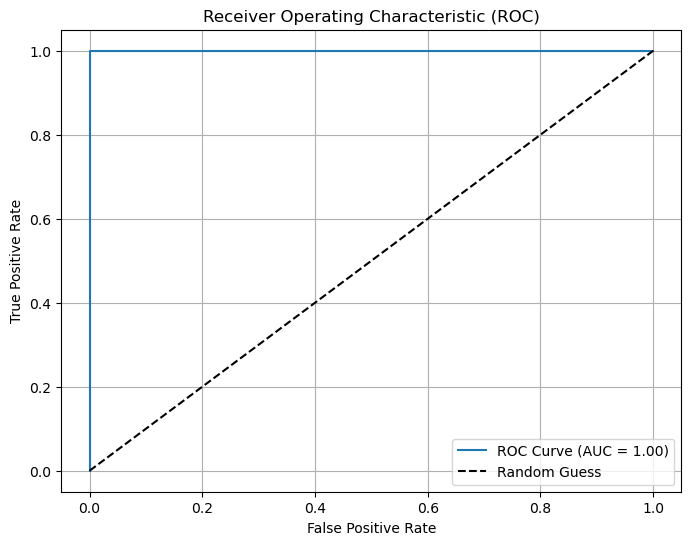

In [22]:
label_1 = "C"
label_2 = "G"
logistic_regression_binary(label_1, label_2, target_size, ''Two different letters (ROC))

In [23]:
def logistic_regression_multiclass(size):
    """
    Train a logistic regression model.
    """
    X, y = preprocess_images(size)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    print("Training")
    logistic_model = LogisticRegression()
    logistic_model.fit(X_train, y_train)

    print("Evaluating")
    y_pred = logistic_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

    print('Accuracy: ' + str(accuracy))
    print('Confusion Matrix: ')
    print(conf_matrix)
    print('Recall: ' + str(recall))
    print('Precision: ' + str(precision))
    print('F1_score: ' + str(f1))
    print('Classification Report: ')
    print(report)

In [24]:
logistic_regression_multiclass(target_size)

100%|██████████████████████████████████████████████████████████████████████████| 87000/87000 [00:36<00:00, 2404.92it/s]


Training
Evaluating
Accuracy: 0.49195402298850577
Confusion Matrix: 
[[299  77   8  27  45  16  19   7  15   0  25  18   2   0   4   0   1   0
    9   7   5   0   0   1   0   9   0   4   2]
 [ 52 281  25  23  36  27   8   3  16   2  21  11   7   0   4   0   0   0
   21   6   1   0   0   1   0   3   0  52   0]
 [ 23  18 370  72  23   0   2   0  11   0   4   3  13   0  11  10   3   0
    1   7   3   0   0   1   2   8   1   3  11]
 [ 43  40  88 260  40   7   9   4  11   0  10  28   4   0  24   1   0   1
    0  10   0   0   0   0   1   3   1  14   1]
 [ 54  49  37  39 244  52   4   8  29   1  18  11   1   1   8   1   0   1
    5  15   0   0   0   0   1   7   0  14   0]
 [ 55  43  37  15  33 275  18  15  19   7  14  17   0   3   7   0   0   0
    0  13   0   0   0   6   0   0   0  20   3]
 [  2   3   7   1   2   5 298 142  18  44  34   0   4  11   0   4   0   0
    2   0   0   0   0   1   6   0   0   0  16]
 [  0   1   0   0   0  10  65 376   2  53  15   2   3  14   2  13  16   0
    1   0 

C:\Users\Victoria\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The logistic regression performs relatively well, depending on the form of the input. 

- When the two letters are similar, the model performs relatively well; and accuracy and other scores are high.
  
- When the two letters are different, the model performs extremely well, with a 100% accuracy.
  
- When running with all letters the model does not perform well, better than expected (> 20%) but lower than good score (<80%)

=> This shows that the logistic regression can separate and classify hand signals especially well when the two labels are visually different.

As discussed, The logistic regression model is to be used as a baseline to compared to the main model - CNN. Because of high scores and accuracy of logistic regression models =>  we expecting CNNs will also perform well.

# ResNet:

# CNN:

In [25]:
def cnn_models(cnn_model, size):
    """
    Train a CNN model
    """
    X, y = preprocess_images(size)
    
    X = X[..., np.newaxis]
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y = to_categorical(y_encoded)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_encoded)

    print('Modelling')
    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64, verbose=1)

    print('Evaluating')
    loss, accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
    y_pred_prob = cnn_model.predict(X_test, verbose=0)
    y_pred = y_pred_prob.argmax(axis=1)
    y_true = y_test.argmax(axis=1)
    auc_score = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
    report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_true, y_pred)

    print('Test Loss: ' + str(loss))
    print('Test Accuracy: ' + str(accuracy))
    print('Precision: ' + str(precision))
    print('Recall: ' + str(recall))
    print('F1: ' + str(f1))
    print('AUC Score: ' + str(auc_score))

    print('Classification Report: ')
    print(report)

    print('Confusion Matrix: ')
    print(conf_matrix)

#### 1 hidden layers

In [26]:
# 1 hidden layer (32 Filters), Input Size (32, 32)
model1_32 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(29, activation='softmax')
])
model1_32.summary()

C:\Users\Victoria\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         460,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 29)                  │           1,885 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 463,069 (1.77 MB)

 Trainable params: 463,069 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
cnn_models(model1_32, target_size)

100%|██████████████████████████████████████████████████████████████████████████| 87000/87000 [00:36<00:00, 2416.47it/s]


Modelling
Epoch 1/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.0444 - loss: 3.3222 - val_accuracy: 0.1780 - val_loss: 2.8225
Epoch 2/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.1475 - loss: 2.8072 - val_accuracy: 0.4509 - val_loss: 1.9853
Epoch 3/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.2453 - loss: 2.3153 - val_accuracy: 0.5492 - val_loss: 1.5743
Epoch 4/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.2965 - loss: 2.0929 - val_accuracy: 0.6121 - val_loss: 1.3917
Epoch 5/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.3381 - loss: 1.9444 - val_accuracy: 0.6612 - val_loss: 1.2097
Evaluating
Test Loss: 1.2097182273864746
Test Accuracy: 0.6612069010734558
Precision: 0.6778196938594905
Recall: 0.6612068965517242
F1: 0.6575071737571923
AUC Score: 0.9767795463875204
Classification Report: 
              precision    recall  f1-score   support

           A       0.75      0.45      0.56       600
           B       0.6

In [28]:
# 1 hidden layer (32 Filters), Input Size (16,16)
model1_16 = Sequential([
    Input(shape=(16, 16, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(29, activation='softmax')
])
model1_32.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         460,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 29)                  │           1,885 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,389,209 (5.30 MB)

 Trainable params: 463,069 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 926,140 (3.53 MB)

In [29]:
cnn_models(model1_16, reduced_size)

100%|██████████████████████████████████████████████████████████████████████████| 87000/87000 [00:35<00:00, 2447.47it/s]


Modelling
Epoch 1/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0874 - loss: 3.1816 - val_accuracy: 0.3932 - val_loss: 2.1815
Epoch 2/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2695 - loss: 2.3349 - val_accuracy: 0.5239 - val_loss: 1.6983
Epoch 3/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3497 - loss: 1.9972 - val_accuracy: 0.6081 - val_loss: 1.4336
Epoch 4/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3979 - loss: 1.8208 - val_accuracy: 0.6382 - val_loss: 1.2890
Epoch 5/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4288 - loss: 1.7077 - val_accuracy: 0.6859 - val_loss: 1.1385
Evaluating
Test Loss: 1.1384809017181396
Test Accuracy: 0.6859195232391357
Precision: 0.6905302622313022
Recall: 0.6859195402298849
F1: 0.6766193237417555
AUC Score: 0.9787830511083743
Classification Report: 
              precision    recall  f1-score   support

           A       0.62      0.62      0.62       600
           B       0.69    

In [30]:
# 2 Hidden Layers (32, 64 Filters), Input Size (32, 32)
model2_32 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(29, activation='softmax')  # Replace 29 with the number of classes
])
model2_32.summary()

C:\Users\Victoria\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 29)                  │           3,741 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 317,597 (1.21 MB)

 Trainable params: 317,597 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
cnn_models(model2_32, target_size)

100%|██████████████████████████████████████████████████████████████████████████| 87000/87000 [00:35<00:00, 2429.69it/s]


Modelling
Epoch 1/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.1590 - loss: 2.9007 - val_accuracy: 0.6654 - val_loss: 1.2317
Epoch 2/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.5206 - loss: 1.4707 - val_accuracy: 0.7962 - val_loss: 0.7639
Epoch 3/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.6173 - loss: 1.1343 - val_accuracy: 0.8587 - val_loss: 0.5626
Epoch 4/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.6731 - loss: 0.9452 - val_accuracy: 0.8993 - val_loss: 0.4296
Epoch 5/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.7190 - loss: 0.8206 - val_accuracy: 0.9194 - val_loss: 0.3440
Evaluating
Test Loss: 0.34396690130233765
Test Accuracy: 0.919367790222168
Precision: 0.9225012389915309
Recall: 0.9193678160919541
F1: 0.9196274247452421
AUC Score: 0.9984042863984673
Classification Report: 
              precision    recall  f1-score   support

           A       0.85      0.97      0.90       600
           B     

In [32]:
# 2 Hidden Layers (16, 32 Filters), Input Size (16, 16)
model2_16 = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(reduced_size[0], reduced_size[1], 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(29, activation='softmax')  # Replace 29 with the number of classes
])
model2_16.summary()

C:\Users\Victoria\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 5, 5, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 29)                  │           1,885 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,941 (58.36 KB)

 Trainable params: 14,941 (58.36 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
cnn_models(model2_16, reduced_size)

100%|██████████████████████████████████████████████████████████████████████████| 87000/87000 [00:35<00:00, 2423.05it/s]


Modelling
Epoch 1/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0757 - loss: 3.2348 - val_accuracy: 0.3493 - val_loss: 2.2679
Epoch 2/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2634 - loss: 2.4216 - val_accuracy: 0.4568 - val_loss: 1.8503
Epoch 3/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3318 - loss: 2.1436 - val_accuracy: 0.5143 - val_loss: 1.6732
Epoch 4/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3612 - loss: 2.0120 - val_accuracy: 0.5391 - val_loss: 1.5353
Epoch 5/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3902 - loss: 1.9169 - val_accuracy: 0.5710 - val_loss: 1.4418
Evaluating
Test Loss: 1.4418365955352783
Test Accuracy: 0.5710344910621643
Precision: 0.5817492704951465
Recall: 0.5710344827586207
F1: 0.5575669370276566
AUC Score: 0.9599896158319648
Classification Report: 
              precision    recall  f1-score   support

           A       0.59      0.69      0.64       600
           B       0.59    

In [34]:
# 3 Hidden Layers (32, 64, 64 Filters), Input Size (32, 32)
model3_32 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(29, activation='softmax')
])
model3_32.summary()

C:\Users\Victoria\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 29)                  │           3,741 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,381 (360.86 KB)

 Trainable params: 92,381 (360.86 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
cnn_models(model3_32, target_size)

100%|██████████████████████████████████████████████████████████████████████████| 87000/87000 [00:37<00:00, 2343.43it/s]


Modelling
Epoch 1/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.1499 - loss: 2.9251 - val_accuracy: 0.6494 - val_loss: 1.1796
Epoch 2/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.5362 - loss: 1.4069 - val_accuracy: 0.8118 - val_loss: 0.6645
Epoch 3/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.6620 - loss: 1.0037 - val_accuracy: 0.8717 - val_loss: 0.4698
Epoch 4/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.7236 - loss: 0.8057 - val_accuracy: 0.9073 - val_loss: 0.3536
Epoch 5/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.7636 - loss: 0.6871 - val_accuracy: 0.9309 - val_loss: 0.2810
Evaluating
Test Loss: 0.2810458838939667
Test Accuracy: 0.9308620691299438
Precision: 0.9338371571031637
Recall: 0.9308620689655172
F1: 0.9306921061295939
AUC Score: 0.9987839559386973
Classification Report: 
              precision    recall  f1-score   support

           A       0.93      0.94      0.93       600
           B     

In [36]:
model3_16 = Sequential([
    Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(16, 16, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),  # Optional: Remove this pooling layer if still too small
    Dropout(0.25),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(29, activation='softmax')  # Replace 29 with the number of classes
])

model3_16.summary()

C:\Users\Victoria\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 29)                  │           1,885 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,189 (94.49 KB)

 Trainable params: 24,189 (94.49 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
cnn_models(model3_16, reduced_size)

100%|██████████████████████████████████████████████████████████████████████████| 87000/87000 [00:35<00:00, 2447.75it/s]


Modelling
Epoch 1/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0723 - loss: 3.2160 - val_accuracy: 0.3839 - val_loss: 2.0133
Epoch 2/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2933 - loss: 2.2119 - val_accuracy: 0.5278 - val_loss: 1.5339
Epoch 3/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3769 - loss: 1.8870 - val_accuracy: 0.5909 - val_loss: 1.3135
Epoch 4/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4207 - loss: 1.7392 - val_accuracy: 0.6370 - val_loss: 1.1866
Epoch 5/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4520 - loss: 1.6290 - val_accuracy: 0.6607 - val_loss: 1.0980
Evaluating
Test Loss: 1.0980294942855835
Test Accuracy: 0.6607471108436584
Precision: 0.692018259091957
Recall: 0.6607471264367817
F1: 0.6527432018289607
AUC Score: 0.9781509270662287
Classification Report: 
              precision    recall  f1-score   support

           A       0.64      0.83      0.72       600
           B       0.76     